# CSE 252A Computer Vision I Fall 2018 - Assignment 2

### Instructor: David Kriegman
### Assignment Published On: Wednesday, October 24, 2018
### Due On: Wednesday, November 7, 2018 11:59 pm

## Instructions
* Review the academic integrity and collaboration policies on the course website.
* This assignment must be completed individually.
* This assignment contains theoretical and programming exercises. If you plan to submit hand written answers for theoretical exercises, please be sure your writing is readable and merge those in order with the final pdf you create out of this notebook. You could fill the answers within the notebook iteself by creating a markdown cell.
* Programming aspects of this assignment must be completed using Python in this notebook.
* If you want to modify the skeleton code, you can do so. This has been provided just to provide you with a framework for the solution.
* You may use python packages for basic linear algebra (you can use numpy or scipy for basic operations), but you may not use packages that directly solve the problem.
* If you are unsure about using a specific package or function, then ask the instructor and teaching assistants for clarification.
* You must submit this notebook exported as a pdf. You must also submit this notebook as .ipynb file.
* You must submit both files (.pdf and .ipynb) on Gradescope. You must mark each problem on Gradescope in the pdf.
* **Late policy** - 10% per day late penalty after due date up to 3 days.

## Problem 1: Steradians [2 pts]
Calculate the number of steradians contained in a spherical wedge with radius $r = 1$, defined by $\theta=\frac{\pi}{6}$, $\phi=\frac{\pi}{6}$ centered around vector $(\frac{\sqrt{2}}{4}, \frac{\sqrt{2}}{4}, \frac{\sqrt{3}}{2})$.
<img src="Problem1 spherical wedge.jpg">

## Problem 2: Irradiance [6 pts]

Consider a camera looking at Lambertian wall with constant albedo, illuminated by a light source at infinity such that the radiance emitted by the wall is $L$ in all directions. The angle between the optical axis and the wall’s surface normal is 60 degrees. The focal length of the camera is 50mm, and the pixels are 1mm by 1mm.

<img src = 'Problem2 irradiance.jpg'>

We will solve this for a pixel centered at the optical axis and also consider three distances along the line of sight between the pinhole and wall (1000mm, 2000mm, 4000mm). We will also walk through four steps and take advantage of small area approximations.

1. Start with $d=1000\text{ mm}$, 
    1. If the wall is parallel to the image plane at distance $d$, what is the area of the wall that projects to the central pixel?
    1. Now, if the wall is tilted by 60 degrees, what is the area of the wall that projects to the pixel (you can treat this as a small area and can neglect an perspective distortion). Call this $dA_{1}$.
    1. If we treat the pinhole as having a small area $dA_{2}$ that is parallel to the image plane, what is the power received at $dA_{2}$?
    1. If all the power received at $dA_{2}$ passes through the pinhole and is received by the central pixel, what is the irradiance at the central pixel?
1. What is the irradiance at the central pixel  for $d=2000\text{ mm}$?
1. What is the irradiance at the central pixel  for $d=4000\text{ mm}$?
1. What can you learn about image irradiance as a function fo distance from this example?

## Problem 3: Diffused Objects and Brightness [4 pts]

We see a diffuse torus centered at the origin in an orthographic camera, looking down the z-axis. The parameters of the torus are shown in the Figure "Problem3 torus" and the albedo is $\rho$.


<img src="Problem3 torus.png">

This torus is illuminated by a distant point light source whose direction is $(0,0,1)$. There is no other illumination. 

What is the brightness at a point $(x, y)$ on the surface?

## Problem 4: Occlusion, Umbra and Penumbra [2 pts]
We have a square area source and a square occluder, both parallel to a plane. 

The edge lengths of the source and occluder are 2 and 4, respectively, and they are vertically above one another with their centers aligned. The distances from the occluder to the source and plane are both 3.

1. What is the area of the umbra on the plane?

2. What is the area of the penumbra on the plane?

## Problem 5: Photometric Stereo, Specularity Removal [14 pts]

The goal of this problem is to implement a couple of different algorithms that reconstruct a surface using the concept of photometric stereo.

Additionally, you will implement the specular removal technique of Mallick et al., which enables photometric stereo reconstruction of certain non-Lambertian materials. 

You can assume a Lambertian reflectance function once specularties are removed, but the albedo is unknown and non-constant in the images.  

Your program will take in multiple images as input along with the light source direction (and color when necessary) for each image.

### Data
Synthetic Images, Specular Sphere Images, Pear Images for Part 1, 2, 3: Available in `*.pickle` files (graciously provided by Satya Mallick) which contain

* `im1`, `im2`, `im3`, `im4`... images.

* `l1`, `l2`, `l3`, `l4`... light source directions.

* `c` (when required) color of light source.

### Part 1: [6 pts]

Implement the photometric stereo technique described in Forsyth and Ponce 2.2.4 (*Photometric Stereo: Shape from Multiple Shaded Images*) and the lecture notes. 

Your program should have two parts:

1. Read in the images and corresponding light source directions, and estimate the surface normals and albedo map.

1. Reconstruct the depth map from the surface normals. You can first try the naive scanline-based shape by integration method described in the book.  If this does not work well on real images, you can use the implementation of the Horn integration technique given below in `horn_integrate` function.

Try using only `im1`, `im2` and `im4` first. Display your outputs as mentioned below.

Then use all four images. (Most accurate).

For each of the above cases you must output:

1. The estimated albedo map.

1. The estimated surface normals by showing both
    1. Needle map, and
    1. Three images showing components of surface normal.

1. A wireframe of depth map.

An example of outputs is shown in the Figure "Problem5 example".


<img src="Problem5 example.png">

Note: You will find all the data for this part in `synthetic_data.pickle`.

Keys: dict_keys(['__version__', 'l4', '__header__', 'im1', 'im3', 'im2', 'l2', 'im4', 'l1', '__globals__', 'l3'])
Image:


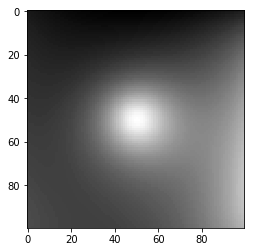

Light source direction: [[0 0 1]]


In [8]:
## Example: How to read and access data from a pickle
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
pickle_in = open("synthetic_data.pickle", "rb")
#data = pickle.load(pickle_in)
data = pickle.load(pickle_in, encoding="latin1")

# data is a dict which stores each element as a key-value pair. 
print("Keys: " + str(data.keys()))

# To access the value of an entity, refer it by its key.
print("Image:")
plt.imshow(data["im1"], cmap = "gray")
plt.show()

print("Light source direction: " + str(data["l1"]))

In [9]:
import numpy as np
from scipy.signal import convolve
from numpy import linalg

def horn_integrate(gx, gy, mask, niter):
    '''
    horn_integrate recovers the function g from its partial 
    derivatives gx and gy. 
    mask is a binary image which tells which pixels are 
    involved in integration. 
    niter is the number of iterations. 
    typically 100,000 or 200,000, 
    although the trend can be seen even after 1000 iterations.
    '''    
    g = np.ones(np.shape(gx))
    
    gx = np.multiply(gx, mask)
    gy = np.multiply(gy, mask)
    
    A = np.array([[0,1,0],[0,0,0],[0,0,0]]) #y-1
    B = np.array([[0,0,0],[1,0,0],[0,0,0]]) #x-1
    C = np.array([[0,0,0],[0,0,1],[0,0,0]]) #x+1
    D = np.array([[0,0,0],[0,0,0],[0,1,0]]) #y+1
    
    d_mask = A + B + C + D
    
    den = np.multiply(convolve(mask,d_mask,mode="same"),mask)
    den[den == 0] = 1
    rden = 1.0 / den
    mask2 = np.multiply(rden, mask)
    
    m_a = convolve(mask, A, mode="same")
    m_b = convolve(mask, B, mode="same")
    m_c = convolve(mask, C, mode="same")
    m_d = convolve(mask, D, mode="same")
    
    term_right = np.multiply(m_c, gx) + np.multiply(m_d, gy)
    t_a = -1.0 * convolve(gx, B, mode="same")
    t_b = -1.0 * convolve(gy, A, mode="same")
    term_right = term_right + t_a + t_b
    term_right = np.multiply(mask2, term_right)
    
    for k in range(niter):
        g = np.multiply(mask2, convolve(g, d_mask, mode="same")) + term_right
    
    return g

In [10]:
def photometric_stereo(images, lights, mask):
    '''
    your implementaion
    '''    
    albedo = np.zeros(images[:,:,0].shape)
  
        
    normals = np.dstack((np.zeros(images[:,:,0].shape),
                         np.zeros(images[:,:,0].shape),
                         np.zeros(images[:,:,0].shape)))
    
    H = np.zeros(images[:,:,0].shape)
    H_horn = np.ones(images[:,:,0].shape)
    
    P = np.zeros(images[:,:,0].shape) # x direction j
    Q = np.zeros(images[:,:,0].shape) # y direction i
    A = (np.linalg.inv((lights.T).dot(lights))).dot(lights.T) # normal(x, y) = (light.T * light)^-1 * intensity(x, y)
    # where lights is a matrix (3 differen lights * 3 direction dimension)

    for i in range(images[:,:,0].shape[0]): # row direction, y
        for j in range(images[:,:,0].shape[1]): # column direction, x
            G_ij = A.dot(images[i,j,:])
            albedo[i][j] = np.linalg.norm(G_ij)
            normals[i][j] = G_ij / albedo[i][j]
            
            P[i][j] = normals[i][j][0] / normals[i][j][2] # df/dx
            Q[i][j] = normals[i][j][1] / normals[i][j][2] # df/dy 
            
           
    for j in range(1,images[:,:,0].shape[1]): # integral of first row, along x direction
        H[0][j] = H[0][j-1] + P[0][j]
    
    for j in range(0,images[:,:,0].shape[1]): # in x direction
        for i in range(0, images[:,:,0].shape[0]): # in y direction
            H[i][j] = H[i-1][j] + Q[i][j]
            
            
    H_horn = horn_integrate(P,Q,mask,10000)
    
    return albedo,normals,H,H_horn
    

using only im1, im2, im4


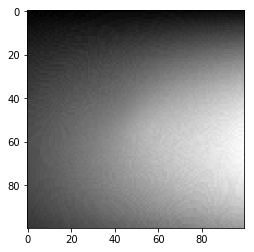

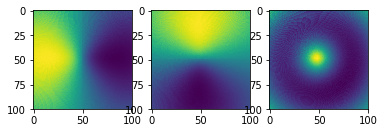

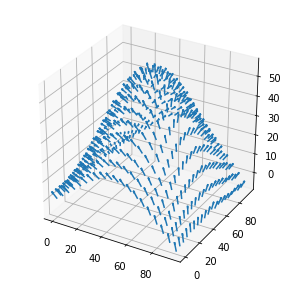

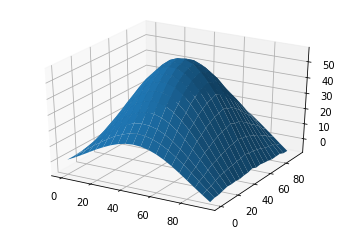

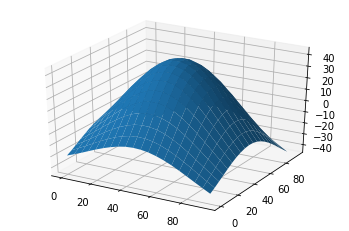

In [11]:
from mpl_toolkits.mplot3d import Axes3D

pickle_in = open("synthetic_data.pickle", "rb")
#data = pickle.load(pickle_in)
data = pickle.load(pickle_in, encoding="latin1")

lights = np.vstack((data["l1"], data["l2"], data["l4"]))
# lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))

images = []
images.append(data["im1"])
images.append(data["im2"])
# images.append(data["im3"])
images.append(data["im4"])
images = np.array(images)
images = images.transpose(1,2,0)


mask = np.ones(data["im1"].shape)

albedo, normals, depth, horn = photometric_stereo(images, lights, mask)

# --------------------------------------------------------------------------
# Following code is just a working example so you don't get stuck with any
# of the graphs required. You may want to write your own code to align the
# results in a better layout.
# --------------------------------------------------------------------------

# Stride in the plot, you may want to adjust it to different images
stride = 5

print('using only im1, im2, im4')
# showing albedo map
fig = plt.figure()
albedo_max = albedo.max()
albedo = albedo / albedo_max
plt.imshow(albedo, cmap="gray")
plt.show()

# showing normals as three separate channels
figure = plt.figure()
ax1 = figure.add_subplot(131)
ax1.imshow(normals[..., 0])
ax2 = figure.add_subplot(132)
ax2.imshow(normals[..., 1])
ax3 = figure.add_subplot(133)
ax3.imshow(normals[..., 2])
plt.show()

# showing normals as quiver
X, Y, _ = np.meshgrid(np.arange(0,np.shape(normals)[0], stride),
                      np.arange(0,np.shape(normals)[1], stride),
                      np.arange(1))
X = X[..., 0]
Y = Y[..., 0]
Z = depth[::stride,::stride].T


NX = normals[..., 0][::stride,::-stride].T
NY = normals[..., 1][::-stride,::stride].T
NZ = normals[..., 2][::stride,::stride].T


fig = plt.figure(figsize=(5, 5))
ax = fig.gca(projection='3d')
plt.quiver(X, Y, Z, NX, NY, NZ, length = 5)
plt.show()

# plotting wireframe depth map
H = depth[::stride,::stride]
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X,Y, H.T)
plt.show()

H = horn[::stride,::stride]
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X,Y, H.T)
plt.show()

using only im1, im2, im3, im4


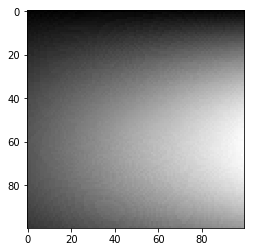

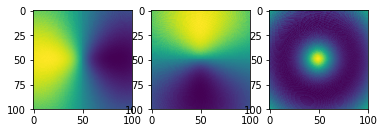

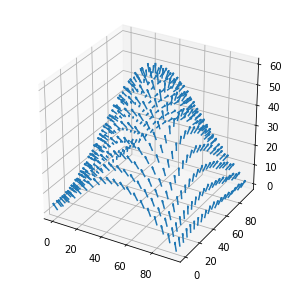

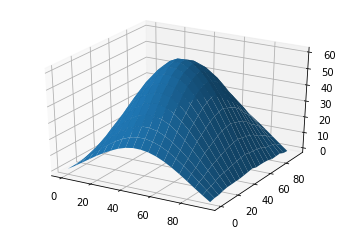

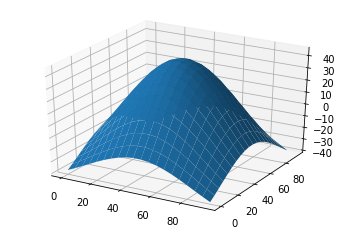

In [12]:
from mpl_toolkits.mplot3d import Axes3D

pickle_in = open("synthetic_data.pickle", "rb")
#data = pickle.load(pickle_in)
data = pickle.load(pickle_in, encoding="latin1")

lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))
# lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))

images = []
images.append(data["im1"])
images.append(data["im2"])
images.append(data["im3"])
images.append(data["im4"])
images = np.array(images)
images = images.transpose(1,2,0)


mask = np.ones(data["im1"].shape)
albedo, normals, depth, horn = photometric_stereo(images, lights, mask)

# --------------------------------------------------------------------------
# Following code is just a working example so you don't get stuck with any
# of the graphs required. You may want to write your own code to align the
# results in a better layout.
# --------------------------------------------------------------------------

# Stride in the plot, you may want to adjust it to different images
stride = 5

print('using only im1, im2, im3, im4')
# showing albedo map
fig = plt.figure()
albedo_max = albedo.max()
albedo = albedo / albedo_max
plt.imshow(albedo, cmap="gray")
plt.show()

# showing normals as three separate channels
figure = plt.figure()
ax1 = figure.add_subplot(131)
ax1.imshow(normals[..., 0])
ax2 = figure.add_subplot(132)
ax2.imshow(normals[..., 1])
ax3 = figure.add_subplot(133)
ax3.imshow(normals[..., 2])
plt.show()

# showing normals as quiver
X, Y, _ = np.meshgrid(np.arange(0,np.shape(normals)[0], stride),
                      np.arange(0,np.shape(normals)[1], stride),
                      np.arange(1))
X = X[..., 0]
Y = Y[..., 0]
Z = depth[::stride,::stride].T


NX = normals[..., 0][::stride,::-stride].T
NY = normals[..., 1][::-stride,::stride].T
NZ = normals[..., 2][::stride,::stride].T


fig = plt.figure(figsize=(5, 5))
ax = fig.gca(projection='3d')
plt.quiver(X, Y, Z, NX, NY, NZ, length = 5)
plt.show()

# plotting wireframe depth map
H = depth[::stride,::stride]
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X,Y, H.T)
plt.show()

H = horn[::stride,::stride]
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X,Y, H.T)
plt.show()

### Part 2: [4 pts]
Implement the specularity removal technique described in *Beyond Lambert: Reconstructing Specular Surfaces Using Color* (by Mallick, Zickler, Kriegman, and Belhumeur; CVPR 2005).  

Your program should input an RGB image and light source color and output the corresponding SUV image.  

Try this out first with the specular sphere images and then with the pear images.  
  
For each specular sphere and pear images, include

1. The original image (in RGB colorspace).

1. The recovered $S$ channel of the image.

1. The recovered diffuse part of the image - Use $G = \sqrt{U^2+V^2}$ to represent the diffuse part.

Note: You will find all the data for this part in `specular_sphere.pickle` and `specular_pear.pickle`.

In [13]:
def get_rot_mat(rot_v, unit=None):
    '''
    Takes a vector and returns the rotation matrix required to align the
    unit vector(2nd arg) to it.
    '''
    if unit is None:
        unit = [1.0, 0.0, 0.0]
    
    rot_v = rot_v/np.linalg.norm(rot_v)
    uvw = np.cross(rot_v, unit) #axis of rotation

    rcos = np.dot(rot_v, unit) #cos by dot product
    rsin = np.linalg.norm(uvw) #sin by magnitude of cross product

    #normalize and unpack axis
    if not np.isclose(rsin, 0):
        uvw = uvw/rsin
    u, v, w = uvw

    # Compute rotation matrix 
    R = (
        rcos * np.eye(3) +
        rsin * np.array([
            [ 0, -w,  v],
            [ w,  0, -u],
            [-v,  u,  0]
        ]) +
        (1.0 - rcos) * uvw[:,None] * uvw[None,:]
    )
    return R


def RGBToSUV(I_rgb, rot_vec):
    '''
    your implementation which takes an RGB image and a vector encoding
    the orientation of S channel wrt to RGB
    '''
    # rot_vect is color 
    S = np.ones(I_rgb.shape[:2]) # 455 * 455
    G = np.ones(I_rgb.shape[:2])
    R = get_rot_mat(rot_vec)
    I_suv = np.zeros(I_rgb.shape)

    for i in range(I_rgb.shape[0]):
        for j in range(I_rgb.shape[1]):
            I_suv[i][j] = np.dot(R, I_rgb[i][j])
            S[i][j] = I_suv[i][j][0]
            G[i][j] = np.linalg.norm(I_suv[i][j][1:])
            
            # G is the D projection line
            
    return S, G

### Part 2.1 specular sphere 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


original sphere


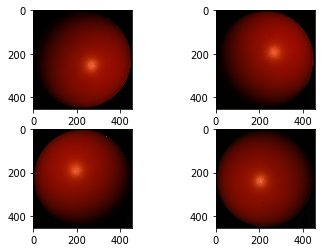

recovered S channel of sphere


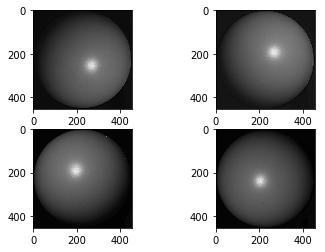

recovered diffuse part of sphere


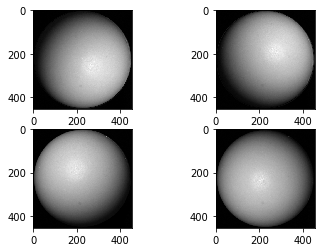

In [14]:
######## specular_sphere ########
pickle_in = open("specular_sphere.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

S1, G1 = RGBToSUV(data["im1"], np.hstack((data["c"][0][0],
                                          data["c"][1][0],
                                          data["c"][2][0])))

S2, G2 = RGBToSUV(data["im2"], np.hstack((data["c"][0][0],
                                          data["c"][1][0],
                                          data["c"][2][0])))

S3, G3 = RGBToSUV(data["im3"], np.hstack((data["c"][0][0],
                                          data["c"][1][0],
                                          data["c"][2][0])))

S4, G4 = RGBToSUV(data["im4"], np.hstack((data["c"][0][0],
                                          data["c"][1][0],
                                          data["c"][2][0])))

print('original sphere')
plt.subplot(2,2,1)
plt.imshow(data['im1']/np.max(data['im1']))
plt.subplot(2,2,2)
plt.imshow(data['im2']/np.max(data['im2']))
plt.subplot(2,2,3)
plt.imshow(data['im3']/np.max(data['im3']))
plt.subplot(2,2,4)
plt.imshow(data['im4']/np.max(data['im4']))
plt.show()

print('recovered S channel of sphere')
plt.subplot(2,2,1)
plt.imshow(S1,cmap='gray')
plt.subplot(2,2,2)
plt.imshow(S2,cmap='gray')
plt.subplot(2,2,3)
plt.imshow(S3,cmap='gray')
plt.subplot(2,2,4)
plt.imshow(S4,cmap='gray')
plt.show()

print('recovered diffuse part of sphere')
plt.subplot(2,2,1)
plt.imshow(G1,cmap='gray')
plt.subplot(2,2,2)
plt.imshow(G2,cmap='gray')
plt.subplot(2,2,3)
plt.imshow(G3,cmap='gray')
plt.subplot(2,2,4)
plt.imshow(G4,cmap='gray')
plt.show()


### Part 2.2 pear

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


original pear


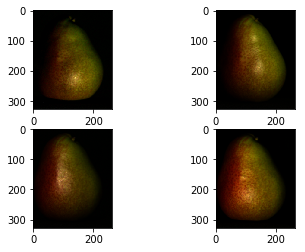

recovered S channel of pear


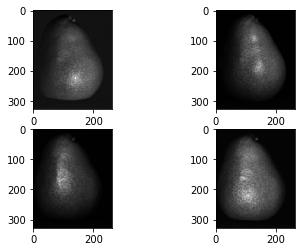

recovered diffuse part of pear


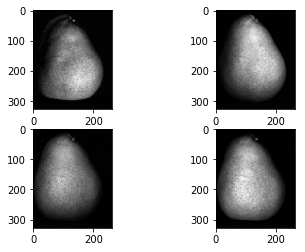

In [15]:
######## pear ########
pickle_in = open("specular_pear.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")
#sample input
S1,G1 = RGBToSUV(data['im1'],np.hstack((data['c'][0][0],data['c'][1][0],data['c'][2][0])))
S2,G2 = RGBToSUV(data['im2'],np.hstack((data['c'][0][0],data['c'][1][0],data['c'][2][0])))
S3,G3 = RGBToSUV(data['im3'],np.hstack((data['c'][0][0],data['c'][1][0],data['c'][2][0])))
S4,G4 = RGBToSUV(data['im4'],np.hstack((data['c'][0][0],data['c'][1][0],data['c'][2][0])))

print('original pear')
plt.subplot(2,2,1)
plt.imshow(data['im1']/np.max(data['im1']))
plt.subplot(2,2,2)
plt.imshow(data['im2']/np.max(data['im2']))
plt.subplot(2,2,3)
plt.imshow(data['im3']/np.max(data['im3']))
plt.subplot(2,2,4)
plt.imshow(data['im4']/np.max(data['im4']))
plt.show()

print('recovered S channel of pear')
plt.subplot(2,2,1)
plt.imshow(S1,cmap='gray')
plt.subplot(2,2,2)
plt.imshow(S2,cmap='gray')
plt.subplot(2,2,3)
plt.imshow(S3,cmap='gray')
plt.subplot(2,2,4)
plt.imshow(S4,cmap='gray')
plt.show()

print('recovered diffuse part of pear')
plt.subplot(2,2,1)
plt.imshow(G1,cmap='gray')
plt.subplot(2,2,2)
plt.imshow(G2,cmap='gray')
plt.subplot(2,2,3)
plt.imshow(G3,cmap='gray')
plt.subplot(2,2,4)
plt.imshow(G4,cmap='gray')
plt.show()

### Part 3: [4 pts]
Combine parts 1 and 2 by running your photometric stereo code on the diffuse components of the specular sphere and pear images. 

For comparison, run your photometric stereo code on the original images (converted to grayscale) as well. You should notice erroneous "bumps" in the resulting reconstructions, as a result of violating the Lambertian assumption.

For each specular sphere and pear image sets, using all the four images, include:

1. The estimated albedo map (original and diffuse)

1. The estimated surface normals (original and diffuse) by showing both

    1. Needle map, and
    1. Three images showing components of surface normal
    
1. A wireframe of depth map (original and diffuse)

In [16]:
# ---------------------------------------------------------------------------
# You may reuse the code for photometric_stereo here.
# Write your code below to process the data and send it to photometric_stereo
# and display the albedo, normals and depth maps.
# ---------------------------------------------------------------------------

from mpl_toolkits.mplot3d import Axes3D
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


def visualization (albedo, normals, depth, horn, words):
    stride = 5
    print(words)
    # showing albedo map
    fig = plt.figure()
    albedo_max = albedo.max()
    albedo = albedo / albedo_max
    plt.imshow(albedo, cmap="gray")
    plt.show()

    # showing normals as three separate channels
    figure = plt.figure()
    ax1 = figure.add_subplot(131)
    ax1.imshow(normals[..., 0])
    ax2 = figure.add_subplot(132)
    ax2.imshow(normals[..., 1])
    ax3 = figure.add_subplot(133)
    ax3.imshow(normals[..., 2])
    plt.show()

    # showing normals as quiver
    X, Y, _ = np.meshgrid(np.arange(0,np.shape(normals)[0], stride),
                          np.arange(0,np.shape(normals)[1], stride),
                          np.arange(1))
    X = X[..., 0]
    Y = Y[..., 0]
    Z = depth[::stride,::stride].T


    NX = normals[..., 0][::stride,::-stride].T
    NY = normals[..., 1][::-stride,::stride].T
    NZ = normals[..., 2][::stride,::stride].T


    fig = plt.figure(figsize=(5, 5))
    ax = fig.gca(projection='3d')
    plt.quiver(X, Y, Z, NX, NY, NZ, length = 5)
    plt.show()

    # plotting wireframe depth map
    H = depth[::stride,::stride]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X,Y, H.T)
    plt.show()

    H = horn[::stride,::stride]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X,Y, H.T)
    plt.show()

# ------------------------------ Specular Sphere ----------------------------

In [17]:
# ------------------------------ Specular Sphere ----------------------------
pickle_in = open("specular_sphere.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")
lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))
mask = np.ones(rgb2gray(data["im1"]).shape)

Original Specular Sphere


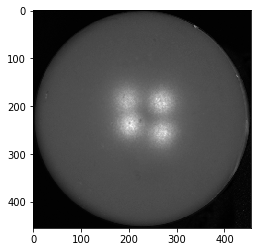

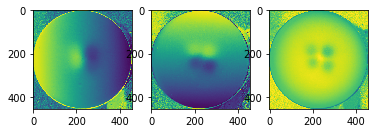

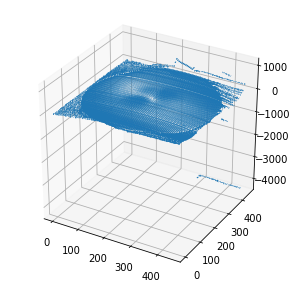

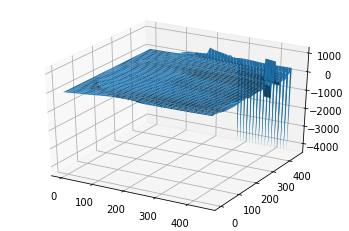

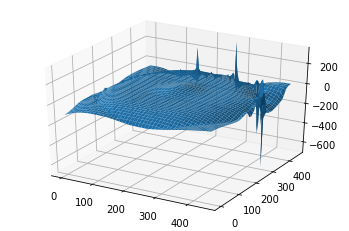

In [18]:
# ------------------------------ Original -----------------------------------
images = []
images.append(rgb2gray(data["im1"]))
images.append(rgb2gray(data["im2"]))
images.append(rgb2gray(data["im3"]))
images.append(rgb2gray(data["im4"]))
images = np.array(images)
images = images.transpose(1,2,0)


albedo, origin_sphere_normals, depth, horn = photometric_stereo(images, lights, mask)
visualization (albedo, origin_sphere_normals, depth, horn, 'Original Specular Sphere')

Diffusion Specular Sphere


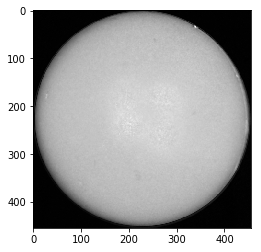

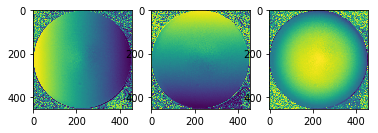

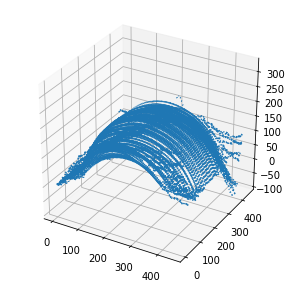

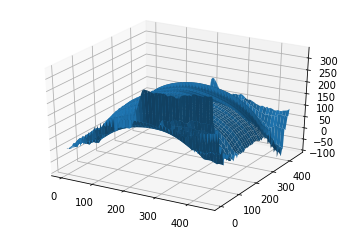

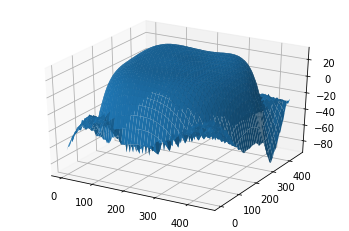

In [19]:
# ------------------------------ Diffusion ----------------------------------
S1,G1 = RGBToSUV(data['im1'],np.hstack((data['c'][0][0],data['c'][1][0],data['c'][2][0])))
S2,G2 = RGBToSUV(data['im2'],np.hstack((data['c'][0][0],data['c'][1][0],data['c'][2][0])))
S3,G3 = RGBToSUV(data['im3'],np.hstack((data['c'][0][0],data['c'][1][0],data['c'][2][0])))
S4,G4 = RGBToSUV(data['im4'],np.hstack((data['c'][0][0],data['c'][1][0],data['c'][2][0])))

images = []
images.append(G1)
images.append(G2)
images.append(G3)
images.append(G4)
images = np.array(images)
images = images.transpose(1,2,0)

albedo, diffuse_sphere_normals, depth, horn = photometric_stereo(images, lights, mask)
visualization (albedo, diffuse_sphere_normals, depth, horn, 'Diffusion Specular Sphere')

# ------------------------------ Specular Pear ------------------------------

In [20]:
# ------------------------------ Specular Pear ------------------------------
pickle_in = open("specular_pear.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")
lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))
mask = np.ones(rgb2gray(data["im1"]).shape)

Original Specular Pear


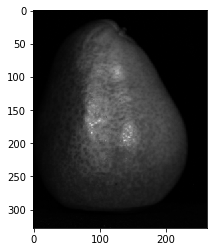

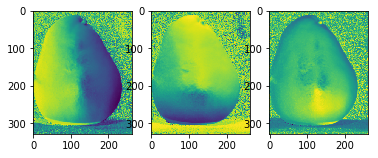

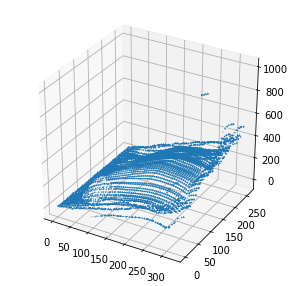

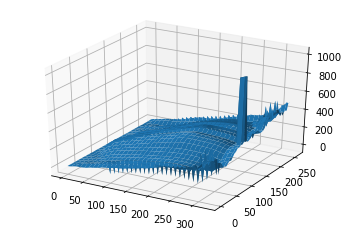

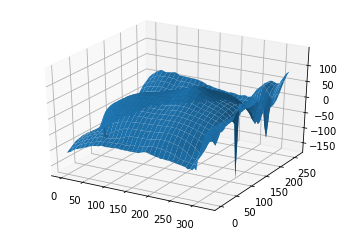

In [21]:
# ------------------------------ Original -----------------------------------
images = []
images.append(rgb2gray(data["im1"]))
images.append(rgb2gray(data["im2"]))
images.append(rgb2gray(data["im3"]))
images.append(rgb2gray(data["im4"]))
images = np.array(images)
images = images.transpose(1,2,0)


albedo, origin_pear_normals, depth, horn = photometric_stereo(images, lights, mask)
visualization (albedo, origin_pear_normals, depth, horn, 'Original Specular Pear')

Diffusion Specular Pear


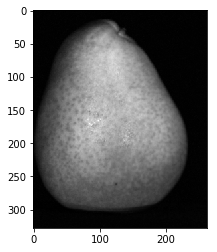

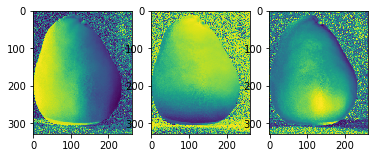

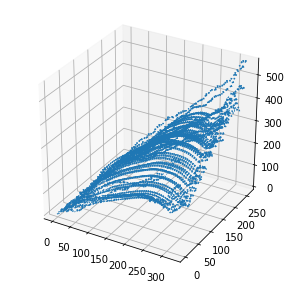

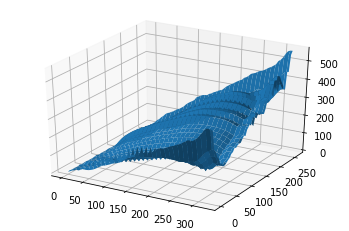

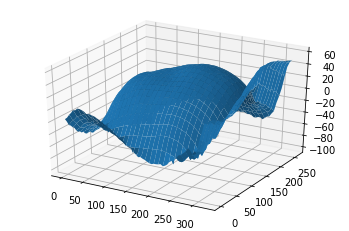

In [22]:
# ------------------------------ Diffusion ----------------------------------
S1,G1 = RGBToSUV(data['im1'],np.hstack((data['c'][0][0],data['c'][1][0],data['c'][2][0])))
S2,G2 = RGBToSUV(data['im2'],np.hstack((data['c'][0][0],data['c'][1][0],data['c'][2][0])))
S3,G3 = RGBToSUV(data['im3'],np.hstack((data['c'][0][0],data['c'][1][0],data['c'][2][0])))
S4,G4 = RGBToSUV(data['im4'],np.hstack((data['c'][0][0],data['c'][1][0],data['c'][2][0])))

images = []
images.append(G1)
images.append(G2)
images.append(G3)
images.append(G4)
images = np.array(images)
images = images.transpose(1,2,0)

albedo, diffuse_pear_normals, depth, horn = photometric_stereo(images, lights, mask)
visualization (albedo, diffuse_pear_normals, depth, horn, 'Diffusion Specular Pear')

## Problem 6: Surface Rendering [10 pts]

In this portion of the assignment we will be exploring different methods of approximating local illumination of
objects in a scene. As discovered in the photometeric stereo portion of this homework, we know that different light
models work better with different view, illumination sources and materials. This last section of the homework will be an exercise in rendering surfaces. Here, you need use the surface normals from Part 3 of Problem 5 to calculate the image intensity of the specular sphere and pear, with various light sources, different materials, and using a number of illumination models. For the sake of simplicity, multiple reflections of light rays, and occlusion of light rays due to object/scene can be ignored.

### Data

The surface normals of the specular sphere and the pear from Part 3 of Problem 5. For comparison, You should display the rendering results for both normals calculated from the original image and the diffuse components.

Assume that the albedo map is uniform.

### Lambertian Illumination

One of the simplest models available to render 3D objections with illumination is the Lambertian model. This
model finds the apparent brightness to an observer using the direction of the light source $\mathbf{L}$ and the normal
vector on the surface of the object $\mathbf{N}$. The brightness intensity at a given point on an object’s surface, $\mathbf{I_d}$, with
a single light source is found using the following relationship:

$$\mathbf{I_d} = \mathbf{L} \cdot \mathbf{N} (I_l\mathbf{C})$$

where, $\mathbf{C}$ and $I_l$ are the the color and intensity of the light source respectively.

### Phong Illumination

One major drawback of Lambertian illumination is that it only considers the diffuse light in its calculation of
brightness intensity. One other major component to illumination rendering is the specular component. The
specular reflectance is the component of light that is reflected in a single direction, as opposed to all directions,
which is the case in diffuse reflectance. One of the most used models to compute surface brightness with specular
components is the Phong illumination model. This model combines ambient lighting, diffused reflectance as well
as specular reflectance to find the brightness on a surface. Phong shading also considers the material in the scene
which is characterized by four values: the ambient reflection constant ($k_a$), the diffuse reflection constant ($k_d$),
the specular reflection constant ($k_s$) and $\alpha$ the Phong constant, which is the ‘shininess’ of an object. Furthermore,
since the specular component produces ‘rays’, only some of which would be observed by a single observer, the
observer’s viewing direction ($\mathbf{V}$) must also be known. For some scene with known material parameters with $M$
light sources the light intensity $\mathbf{I}_{phong}$ on a surface with normal vector $\mathbf{N}$ seen from viewing direction $\mathbf{V}$ can be
computed by:

$$\mathbf{I}_{phong} = k_{a}\mathbf{I}_{a} + \sum_{m\in M}\left\{k_d(\mathbf{L}_{m}\cdot\mathbf{N})\mathbf{I}_{m,d} + k_{s}(\mathbf{R}_{m}\cdot\mathbf{V})^{\alpha}\mathbf{I}_{m,s}\right\}\text{,}$$

$$\mathbf{R}_{m} = 2\mathbf{N}(\mathbf{L}_{m}\cdot\mathbf{N}) - \mathbf{L}_{m}\text{,}$$

where $\mathbf{I}_{a}$, is the color and intensity of the ambient lighting, $\mathbf{I}_{m,d}$ and $\mathbf{I}_{m,s}$ are the color values for the diffuse and
specular light of the $m$th light source.

### Rendering

Please complete the following:

1. Write the function `lambertian()` that calculates the Lambertian light intensity given the light direction $\mathbf{L}$ with color and intensity $\mathbf{C}$ and $I_l = 1$, and normal vector $\mathbf{N}$. Then use this function in a program that calculates and displays the specular sphere and the pear using each of the two lighting sources found in Table 1. *Note: You do not need to worry about material coefficients in this model.*

1. Write the function `phong()` that calculates the Phong light intensity given the material constants $(k_a, k_d, k_s, \alpha)$, $\mathbf{V} = (0, 0, 1)^\top$, $\mathbf{N}$ and some number of $M$ light sources. Then use this function in a program that calculates and displays the specular sphere and the pear using each of the sets of coefficients found in Table 2 with each light source individually, and both light sources combined.

*Hint: To avoid artifacts due to shadows, ensure that any negative intensities found are set to zero.*


Table 1: Light Sources

| $m$ | Location | Color (RGB)  |
| - | ----------- | ----- |
| 1 | $(-\tfrac{1}{3},\tfrac{1}{3},\tfrac{1}{3})^{\top}$ | $(1,1,1)$ |
| 2 | $(1,0,0)^{\top}$     | $(1,.5,.5)$ |

Table 2: Material Coefficients

| Mat. | $k_a$ | $k_d$ | $k_s$ | $\alpha$ |
| - | -------- | ----- | ----- | -------- |
| 1 | $0$ | $0.1$ | $0.75$ | $5$ |
| 2 | $0$ | $0.5$ | $0.1$ | $5$ |
| 3 | $0$ | $0.5$ | $0.5$ | $10$ |

### Part 1. Lambertian model [4 pts]

In [23]:
def lambertian(normals, lights, color, intensity, mask):
    '''Your implementation'''
    image = np.ones((normals.shape[0], normals.shape[1], 3)) # brightness
    
    for i in range(normals.shape[0]):
        for j in range (normals.shape[1]):
            
            image[i][j] = ((normals[i][j])[None,:].dot(lights)) * color * intensity
    
    image[image < 0] = 0
    return image

# ------------------------------ Specular Sphere ------------------------------

In [24]:
pickle_in = open("specular_sphere.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

mask = np.ones(data["im1"].shape[0:2]).astype('bool')

light1 = np.array([-1/3, 1/3, 1/3])
light1 = (light1 / np.linalg.norm(light1))[:,None]
color1 = np.array([1,1,1])

light2 = np.array([1, 0, 0])
light2 = (light2 / np.linalg.norm(light2)) [:,None]
color2 = np.array([1,0.5,0.5])

intensity = 1

color 1
origin


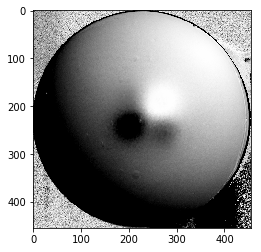

diffuse


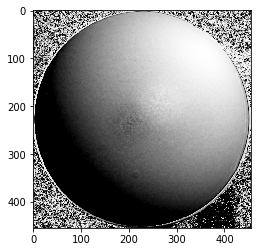

color 2
origin


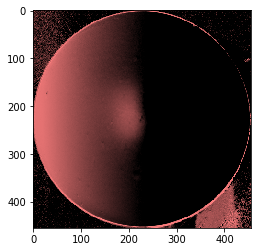

diffuse


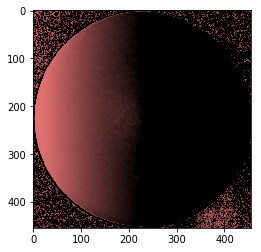

In [25]:
sphere_origin_c1 = lambertian(origin_sphere_normals, light1, color1, intensity, mask)
sphere_diffus_c1 = lambertian(diffuse_sphere_normals, light1, color1, intensity, mask)

sphere_origin_c2 = lambertian(origin_sphere_normals, light2, color2, intensity, mask)
sphere_diffus_c2 = lambertian(diffuse_sphere_normals, light2, color2, intensity, mask)

print('color 1')
print('origin')
plt.imshow(sphere_origin_c1)
plt.show()
print('diffuse')
plt.imshow(sphere_diffus_c1)
plt.show()

print('color 2')
print('origin')
plt.imshow(sphere_origin_c2)
plt.show()
print('diffuse')
plt.imshow(sphere_diffus_c2)
plt.show()




# ------------------------------ Specular Pear ------------------------------

In [26]:
pickle_in = open("specular_pear.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")
mask = np.ones(data["im1"].shape[0:2]).astype('bool')

light1 = np.array([-1/3, 1/3, 1/3])
light1 = (light1 / np.linalg.norm(light1))[:,None]
color1 = np.array([1,1,1])

light2 = np.array([1, 0, 0])
light2 = (light2 / np.linalg.norm(light2)) [:,None]
color2 = np.array([1,0.5,0.5])

intensity = 1

color 1
origin


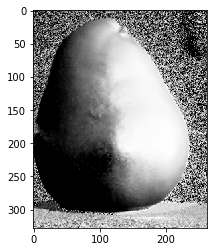

diffuse


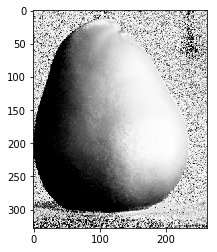

color 2
origin


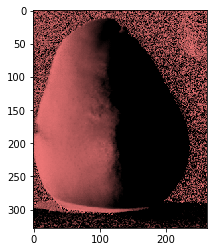

diffuse


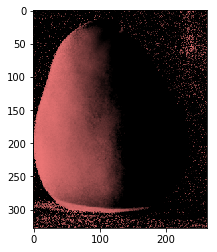

In [27]:
pear_origin_c1 = lambertian(origin_pear_normals, light1, color1, intensity, mask)
pear_diffus_c1 = lambertian(diffuse_pear_normals, light1, color1, intensity, mask)


pear_origin_c2 = lambertian(origin_pear_normals, light2, color2, intensity, mask)
pear_diffus_c2 = lambertian(diffuse_pear_normals, light2, color2, intensity, mask)

print('color 1')
print('origin')
plt.imshow(pear_origin_c1)
plt.show()
print('diffuse')
plt.imshow(pear_diffus_c1)
plt.show()

print('color 2')
print('origin')
plt.imshow(pear_origin_c2)
plt.show()
print('diffuse')
plt.imshow(pear_diffus_c2)
plt.show()

### Part 2. Phong model [6 pts]

In [28]:
def phong(normals, lights, color, material, view, mask):
    '''Your implementation'''
    image = np.zeros((normals.shape[0], normals.shape[1], 3))
    ka, kd, ks, alpha = material[0], material[1], material[2], material[3]
    
    for m, Lm in enumerate(lights):
        for i in range(normals.shape[0]):
            for j in range(normals.shape[1]):
                Rm = 2 * (normals[i][j])[:, None] * Lm.dot((normals[i][j])[:, None]) - Lm[:, None]
                diffuse_reflection = kd * Lm.dot(normals[i][j][:, None]) * color[m][:, None]
                specular_reflection = ks *((Rm.T.dot(view))**alpha) * color[m][:, None]
                m_phone = diffuse_reflection + specular_reflection
                image[i][j][:] += m_phone.squeeze()
            
    image[image<0] = 0
    return image


materials = dict()
materials[0] = [0, 0.1, 0.75, 5]
materials[1] = [0, 0.5, 0.1, 5] 
materials[2] = [0, 0.5, 0.5, 10]
view = np.array([[0],[0],[1]])
mask = 1

# ------------------------------ Specular Sphere ----------------------------

origin
material  1


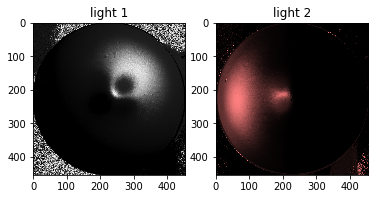

material  2


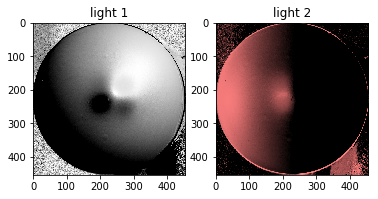

material  3


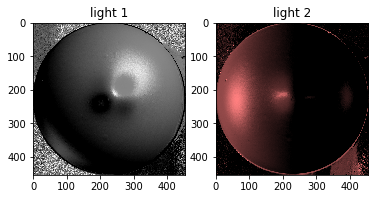

All lights


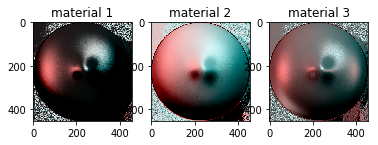

diffuse
material  1


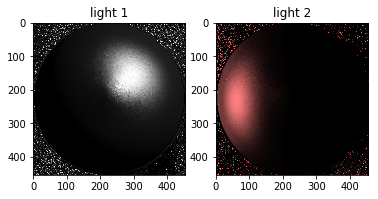

material  2


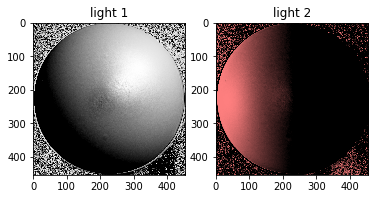

material  3


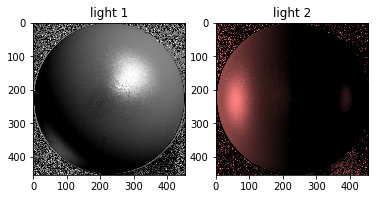

All lights


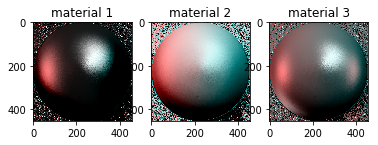

In [29]:
light1 = np.array([-1/3, 1/3, 1/3])
light1 = (light1 / np.linalg.norm(light1))
light2 = np.array([1, 0, 0])
light2 = (light2 / np.linalg.norm(light2))
lights = np.vstack((light1, light2))

color1 = np.array([1,1,1])
color2 = np.array([1,0.5,0.5])
color = [color1, color2]
color = np.array(color)


print('origin')
for j in range(len(materials.keys())):
    print('material ', j + 1)
    for i in range(len(lights)):
        img_i = phong(origin_sphere_normals, lights[i:i+1], color[i:i+1], materials[j], view, mask)
        plt.subplot(1, 2, i +1)
        plt.title('light ' + str(i+1))
        plt.imshow(img_i/np.amax(img_i))
    plt.show()
    
print('All lights')
for j in range(len(materials.keys())):
    img_i = phong(origin_sphere_normals, lights, color, materials[j], view, mask)
    plt.subplot(1, 3, j + 1)
    plt.title('material ' + str(j+1))
    plt.imshow(img_i/np.amax(img_i))
plt.show()


print('diffuse')
for j in range(len(materials.keys())):
    print('material ', j + 1)
    for i in range(len(lights)):
        img_i = phong(diffuse_sphere_normals, lights[i:i+1], color[i:i+1], materials[j], view, mask)
        plt.subplot(1, 2, i +1)
        plt.title('light ' + str(i+1))
        plt.imshow(img_i/np.amax(img_i))
    plt.show()
    
print('All lights')
for j in range(len(materials.keys())):
    img_i = phong(diffuse_sphere_normals, lights, color, materials[j], view, mask)
    plt.subplot(1, 3, j + 1)
    plt.title('material ' + str(j+1))
    plt.imshow(img_i/np.amax(img_i))
plt.show()




# ------------------------------ Specular Pear ----------------------------

origin
material  1


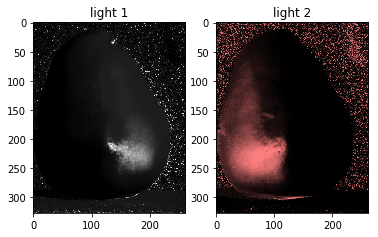

material  2


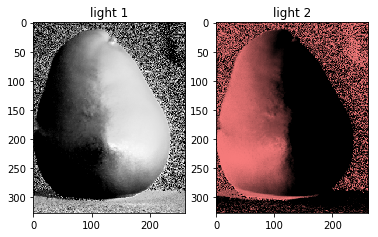

material  3


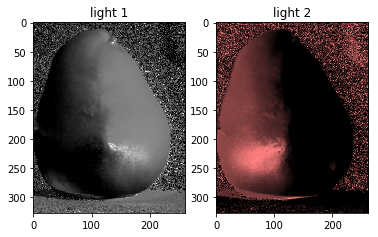

All lights


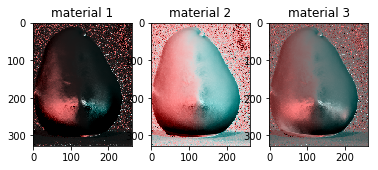

diffuse
material  1


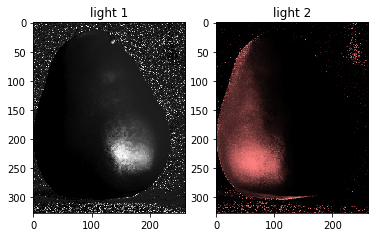

material  2


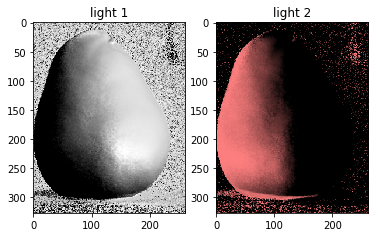

material  3


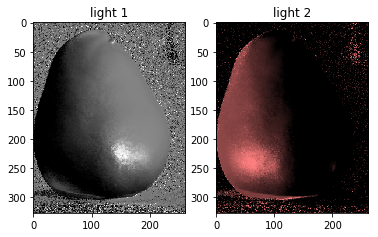

All lights


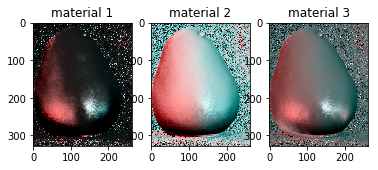

In [30]:
light1 = np.array([-1/3, 1/3, 1/3])
light1 = (light1 / np.linalg.norm(light1))
light2 = np.array([1, 0, 0])
light2 = (light2 / np.linalg.norm(light2))
lights = np.vstack((light1, light2))



color1 = np.array([1,1,1])
color2 = np.array([1,0.5,0.5])
color = [color1, color2]
color = np.array(color)


print('origin')
for j in range(len(materials.keys())):
    print('material ', j + 1)
    for i in range(len(lights)):
        img_i = phong(origin_pear_normals, lights[i:i+1], color[i:i+1], materials[j], view, mask)
        plt.subplot(1, 2, i +1)
        plt.title('light ' + str(i+1))
        plt.imshow(img_i/np.amax(img_i))
    plt.show()


print('All lights')
for j in range(len(materials.keys())):
    img_i = phong(origin_pear_normals, lights, color, materials[j], view, mask)
    plt.subplot(1, 3, j + 1)
    plt.title('material ' + str(j+1))
    plt.imshow(img_i/np.amax(img_i))
plt.show()  


print('diffuse')
for j in range(len(materials.keys())):
    print('material ', j + 1)
    for i in range(len(lights)):
        img_i = phong(diffuse_pear_normals, lights[i:i+1], color[i:i+1], materials[j], view, mask)
        plt.subplot(1, 2, i +1)
        plt.title('light ' + str(i+1))
        plt.imshow(img_i/np.amax(img_i))
    plt.show()


print('All lights')
for j in range(len(materials.keys())):
    img_i = phong(diffuse_pear_normals, lights, color, materials[j], view, mask)
    plt.subplot(1, 3, j + 1)
    plt.title('material ' + str(j+1))
    plt.imshow(img_i/np.amax(img_i))
plt.show()  